#### 그냥 GAN(I Goodfellow, 2014)의 경우

- 학습이 잘 되지 않는다는 고질적인 문제가 있음
- 실제로 앞의 original gan 노트북을 보면 mnist 조차도 생성이 잘 안됨

## DCGAN(A Radford, 2015)의 등장
- 여러 실험을 통해서 성능이 좋으면서 general한 gan architecture를 제시함
- w-gan(M Arjovsky, 2017)의 경우에는 목적함수 측면으로 접근했고 dcgan(A Radford, 2015)은 네트워크 구조적인 측면으로 접근하여 gan 성능을 향상시키는 방향성 제기
- all convolution net(Springenberg et al. 2014)구조와 batch normalization(Ioffe & Szegedy, 2015)을 활용한 것이 특징
- 이후 많은 gan 관련 논문들이 DCGAN 구조를 차용하여 gan 설계 했다함

#### all convolution net(Springenberg et al. 2014)
- 기존에 친숙하게 사용하던 CNN은 VGG(K Simonyan, 2014)같이 conv operation 지난후 max pooling 적용, 반복 후 fully connected를 태우는 구조 
- 근데 이 논문에서는 max pooling 대신 stride 줘서 pooling 효과를 대신하고 마지막에도 fully connected가 아니라 1d convolution 적용함

#### batch normalization(Ioffe & Szegedy, 2015)
- 네트워크 학습을 용이하게 하기 위해 배치 단위로 각 layer의 input을 normalize 하는 것

reference
- Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.
- Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
- Springenberg, Jost Tobias, et al. "Striving for simplicity: The all convolutional net." arXiv preprint arXiv:1412.6806 (2014).
- Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015).
- Arjovsky, Martin, Soumith Chintala, and Léon Bottou. "Wasserstein gan." arXiv preprint arXiv:1701.07875 (2017).
- https://github.com/carpedm20/DCGAN-tensorflow
- https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/dcgan.ipynb
- http://jaejunyoo.blogspot.com/2017/02/deep-convolutional-gan-dcgan-1.html

In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import batch_norm, conv2d, conv2d_transpose, fully_connected

/home/skinet/py_libs/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('/home/skinet/my_glusterfs/ib_study_1/MNIST_data/', one_hot=True)

Extracting /home/skinet/my_glusterfs/ib_study_1/MNIST_data/train-images-idx3-ubyte.gz
Extracting /home/skinet/my_glusterfs/ib_study_1/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /home/skinet/my_glusterfs/ib_study_1/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /home/skinet/my_glusterfs/ib_study_1/MNIST_data/t10k-labels-idx1-ubyte.gz


In [133]:
batch_size = 128
z_dim=100
n_epoches = 20
ran = 1
n_batches = int(mnist.train.images.shape[0]/batch_size)
mnist.train.images.shape[1]

784

In [134]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
phase = tf.placeholder(tf.bool)

In [135]:
def conv(input_, out_dim, name, phase, is_batch_norm = True):
    with tf.variable_scope(name):
        if is_batch_norm: # stride 줘서 pooling 역할 대신하고 batch_normalization 적용
            h = tf.layers.conv2d(input_, out_dim, 5, strides=2,use_bias=False, padding='SAME', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
            out= tf.layers.batch_normalization(h,training=phase)
        else:
            out = tf.layers.conv2d(input_, out_dim, 5, strides=2,padding='SAME', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
            
        return out
            
def conv_transpose(input_, out_dim, name, phase, is_batch_norm = True): # convolution transpose
    with tf.variable_scope(name):
        if is_batch_norm:
            h = tf.layers.conv2d_transpose(input_, out_dim, 5, strides=2, use_bias=False, padding='SAME', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
            out = tf.layers.batch_normalization(h,training=phase)
        else:
            out = tf.layers.conv2d_transpose(input_, out_dim, 5, strides=2, padding='SAME', kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        return out

def fc(input_, out_dim, name, phase, is_batch_norm = True): # 1d convolution으로 할까 하다가 dcgan에서도 이부분이 명확하지 않고 aymericdamien님, carpedm20님의 코드가 fc로 되어있어서...
    with tf.variable_scope(name):
        if is_batch_norm:
            h = tf.layers.dense(input_, out_dim, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
            out = tf.layers.batch_normalization(h,training=phase)
        else:
            out = tf.layers.dense(input_, out_dim, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        
        return out
    
# For the discriminator, the last convolution layer is flattened and then fed into a single sigmoid output => 결국 Wx+b하라는거 아닌가....

#### conv_transpose란?
- https://zzsza.github.io/data/2018/02/23/introduction-convolution/
- https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0

In [136]:
def generator(z):
    with tf.variable_scope('generator'):
        h0 = tf.nn.relu(fc(z, 7*7*128, name='g_0', phase=phase))
        h0 = tf.reshape(h0, [-1, 7, 7, 128])
        h1 = tf.nn.relu(conv_transpose(h0, 64, name='g_1', phase=phase))
        out = tf.nn.tanh(conv_transpose(h1, 1, name='g_out', phase=phase, is_batch_norm=False)) # 마지막 output은 batchnorm 안거는게 좋음
        
        return out 

def discriminator(input_, reuse = False): # gan의 특성상 discriminator를 한번 더 써서 reuse 추가(gz 구분할때, x 구분할때)
    with tf.variable_scope('discriminator', reuse=reuse):
        h0 = tf.nn.leaky_relu(conv(input_, 64, name='d_0', phase=phase, is_batch_norm=False)) # 저자가 input layer에 걸지 말라해서
        h1 = tf.nn.leaky_relu(conv(h0, 128, name='d_1', phase=phase))
        out = fc(tf.reshape(h1, [-1, 7*7*128]),1,name='d_out',phase=phase, is_batch_norm=False) # 마지막 output은 batchnorm 안거는게 좋음
                               
        return out   

#### 전체적인 구조
- generator는 activation: relu 근데 마지막은 tanh (이 때 -1 ~ 1값이 나오는데 mnist 는 0 ~ 1 값이므로 tranform해주는 작업 따로 함)
- discriminator는 activation: leaky relu

In [137]:
gz = generator(z)
dgz = discriminator(gz)
dx = discriminator(x, reuse=True)

In [138]:
tf.trainable_variables()

[<tf.Variable 'generator/g_0/dense/kernel:0' shape=(100, 6272) dtype=float32_ref>,
 <tf.Variable 'generator/g_0/batch_normalization/gamma:0' shape=(6272,) dtype=float32_ref>,
 <tf.Variable 'generator/g_0/batch_normalization/beta:0' shape=(6272,) dtype=float32_ref>,
 <tf.Variable 'generator/g_1/conv2d_transpose/kernel:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'generator/g_1/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'generator/g_1/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'generator/g_out/conv2d_transpose/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>,
 <tf.Variable 'generator/g_out/conv2d_transpose/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_0/conv2d/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_0/conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_1/conv2d/kernel:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Varia

In [139]:
g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') # aymericdamien님 코드에서 본 꿀팁 1, 전체 variable중 해당 scope에 있는거만 가져오기
g_vars

[<tf.Variable 'generator/g_0/dense/kernel:0' shape=(100, 6272) dtype=float32_ref>,
 <tf.Variable 'generator/g_0/batch_normalization/gamma:0' shape=(6272,) dtype=float32_ref>,
 <tf.Variable 'generator/g_0/batch_normalization/beta:0' shape=(6272,) dtype=float32_ref>,
 <tf.Variable 'generator/g_1/conv2d_transpose/kernel:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'generator/g_1/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'generator/g_1/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'generator/g_out/conv2d_transpose/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>,
 <tf.Variable 'generator/g_out/conv2d_transpose/bias:0' shape=(1,) dtype=float32_ref>]

In [140]:
d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
d_vars

[<tf.Variable 'discriminator/d_0/conv2d/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_0/conv2d/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_1/conv2d/kernel:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_1/batch_normalization/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_1/batch_normalization/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_out/dense/kernel:0' shape=(6272, 1) dtype=float32_ref>,
 <tf.Variable 'discriminator/d_out/dense/bias:0' shape=(1,) dtype=float32_ref>]

In [141]:
# min log(1 - D(G(Z))) => max D(G(Z))
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dgz, labels=tf.ones_like(dgz)))

# max log(D(X)) + log(1-D(G(Z)))
d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dx, labels=tf.ones_like(dx))) + tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dgz, labels=tf.zeros_like(dgz)))

In [142]:
g_adam = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_adam = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)

## 중요포인트!! aymericdamien님 코드에서 본 꿀팁 2

- batch normalization의 경우 네트워크 전체 대상으로 moving mean/std 계산하는데 gan 종류의 경우 generator,discriminator 따로 업데이트 되므로 이를 강제로 분리 시켜줘야함
- 아래와 같이 generator batch norm operation 따로, discriminator batch norm operation 따로 설정
- 이거 안해주면 학습이 제대로 안됨... 크리티컬

In [143]:
tf.get_collection(tf.GraphKeys.UPDATE_OPS)

[<tf.Tensor 'generator/g_0/batch_normalization/AssignMovingAvg:0' shape=(6272,) dtype=float32_ref>,
 <tf.Tensor 'generator/g_0/batch_normalization/AssignMovingAvg_1:0' shape=(6272,) dtype=float32_ref>,
 <tf.Tensor 'generator/g_1/batch_normalization/AssignMovingAvg:0' shape=(64,) dtype=float32_ref>,
 <tf.Tensor 'generator/g_1/batch_normalization/AssignMovingAvg_1:0' shape=(64,) dtype=float32_ref>,
 <tf.Tensor 'discriminator/d_1/batch_normalization/AssignMovingAvg:0' shape=(128,) dtype=float32_ref>,
 <tf.Tensor 'discriminator/d_1/batch_normalization/AssignMovingAvg_1:0' shape=(128,) dtype=float32_ref>,
 <tf.Tensor 'discriminator_1/d_1/batch_normalization/AssignMovingAvg:0' shape=(128,) dtype=float32_ref>,
 <tf.Tensor 'discriminator_1/d_1/batch_normalization/AssignMovingAvg_1:0' shape=(128,) dtype=float32_ref>]

In [144]:
g_bn_para = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
g_bn_para

[<tf.Tensor 'generator/g_0/batch_normalization/AssignMovingAvg:0' shape=(6272,) dtype=float32_ref>,
 <tf.Tensor 'generator/g_0/batch_normalization/AssignMovingAvg_1:0' shape=(6272,) dtype=float32_ref>,
 <tf.Tensor 'generator/g_1/batch_normalization/AssignMovingAvg:0' shape=(64,) dtype=float32_ref>,
 <tf.Tensor 'generator/g_1/batch_normalization/AssignMovingAvg_1:0' shape=(64,) dtype=float32_ref>]

In [145]:
d_bn_para = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
d_bn_para

[<tf.Tensor 'discriminator/d_1/batch_normalization/AssignMovingAvg:0' shape=(128,) dtype=float32_ref>,
 <tf.Tensor 'discriminator/d_1/batch_normalization/AssignMovingAvg_1:0' shape=(128,) dtype=float32_ref>,
 <tf.Tensor 'discriminator_1/d_1/batch_normalization/AssignMovingAvg:0' shape=(128,) dtype=float32_ref>,
 <tf.Tensor 'discriminator_1/d_1/batch_normalization/AssignMovingAvg_1:0' shape=(128,) dtype=float32_ref>]

batch norm operation 분리

In [146]:
with tf.control_dependencies(g_bn_para):
    train_op_g = g_adam.minimize(g_loss, var_list=g_vars)
    
with tf.control_dependencies(d_bn_para):
    train_op_d = d_adam.minimize(d_loss, var_list=d_vars)

In [147]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [148]:
try:
    for i in range(n_epoches):
        for j in range(n_batches):
            batch_x, _ = mnist.train.next_batch(batch_size)
            batch_x = batch_x.reshape([batch_size,28,28,1])
            batch_x = batch_x*2-1
            sess.run([train_op_g, train_op_d], feed_dict={x: batch_x, z:np.random.uniform(-ran,ran,[batch_size,z_dim]), phase:True})
        print_g = sess.run(g_loss, feed_dict={z:np.random.uniform(-ran,ran,[batch_size,z_dim]),phase:True})
        print_d = sess.run(d_loss, feed_dict={x:batch_x, z:np.random.uniform(-ran,ran,[batch_size,z_dim]),phase:True})
        print('g_loss = '+str(print_g))
        print('d_loss = '+str(print_d))
except KeyboardInterrupt:
    print('Stop Iterations')

g_loss = 0.75551724
d_loss = 0.8624749
g_loss = 0.7250598
d_loss = 1.0074375
g_loss = 1.5026808
d_loss = 0.8009883
g_loss = 0.81179786
d_loss = 0.9797878
g_loss = 0.5316615
d_loss = 1.1729816
g_loss = 2.052391
d_loss = 1.0413295
g_loss = 1.2867608
d_loss = 0.6886523
g_loss = 1.5870848
d_loss = 0.90886784
g_loss = 1.0935974
d_loss = 0.7365643
g_loss = 0.7885923
d_loss = 0.8538052
g_loss = 1.1574951
d_loss = 0.6725319
g_loss = 0.7437848
d_loss = 0.9803326
g_loss = 1.0433217
d_loss = 0.70369285
g_loss = 1.4105415
d_loss = 0.66288704
g_loss = 2.053589
d_loss = 0.5633873
g_loss = 1.2126076
d_loss = 0.8029945
g_loss = 2.1581864
d_loss = 0.5693188
g_loss = 1.0947183
d_loss = 0.72849536
g_loss = 1.2264316
d_loss = 0.690928
g_loss = 1.0123668
d_loss = 0.883422


### 확실히 original gan보다 더 잘나옴

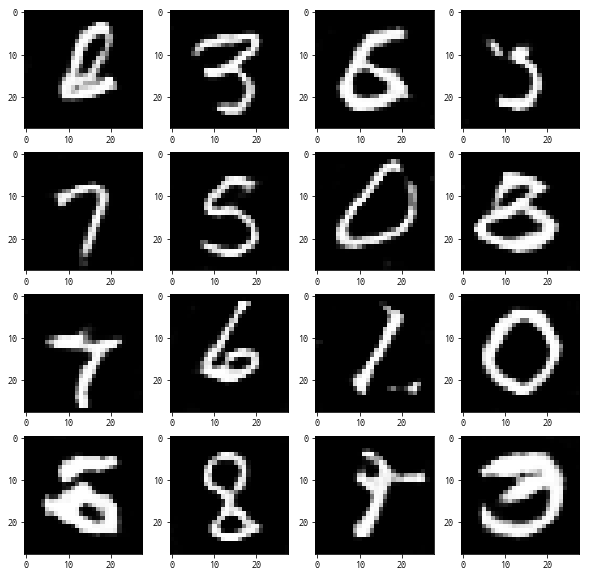

In [149]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((sess.run(gz, feed_dict={z:np.random.uniform(-ran,ran,[batch_size,z_dim]),phase:False})[i].reshape(28,28)+1)/2, cmap='gray')

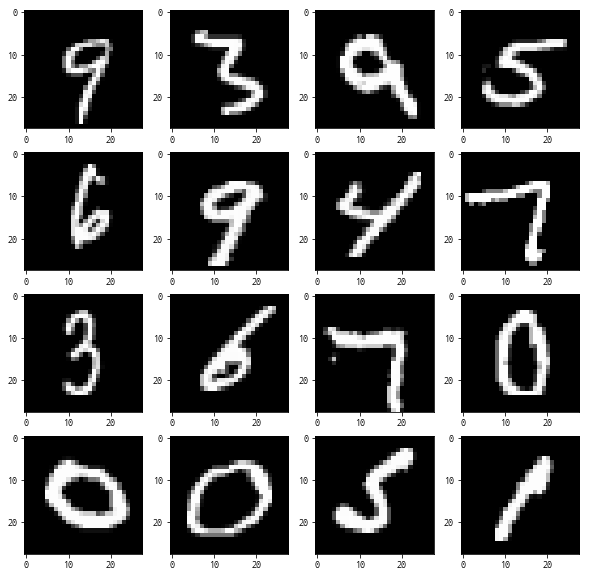

In [82]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(((batch_x[i]+1)/2).reshape(28,28), cmap='gray')